In [2]:
import os
import re
import numpy as np
from glob import glob
from scipy.signal import convolve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pickle

In [3]:
def moving_average_filter(signal, window_size=5):
    """
    Applies a moving average filter (FIR filter with uniform weights)
    to smooth the input signal.
    """
    return np.convolve(signal, np.ones(window_size)/window_size, mode='valid')

def extract_features(signal):
    """
    Extracts simple statistical features from the signal:
    mean, standard deviation, maximum, minimum, and energy.
    """
    mean = np.mean(signal)
    std = np.std(signal)
    maximum = np.max(signal)
    minimum = np.min(signal)
    energy = np.sum(signal**2)
    return np.array([mean, std, maximum, minimum, energy])


In [4]:
def load_segment_files(folder_path):
    """
    Groups CSV files in the given folder into segments by pairing the low band (L) 
    and high band (H) parts. 
    File naming convention: <segmentID><L/H>_<pairIndex>.csv
    e.g., "11000L_1.csv" is the low band and "11000H_1.csv" is the high band.
    The function loads both parts and concatenates them to form a complete segment.
    """
    segment_dict = {}
    # Regular expression to parse filenames (L for low band, H for high band)
    pattern = re.compile(r"(\d+)([LH])_(\d+)\.csv")
    # List all CSV files in the folder
    files = glob(os.path.join(folder_path, "*.csv"))
    
    for file in files:
        basename = os.path.basename(file)
        match = pattern.match(basename)
        if match:
            seg_id = match.group(1)   # e.g., "11000"
            band = match.group(2)     # "L" (low band) or "H" (high band)
            pair_idx = match.group(3) # e.g., "1"
            key = (seg_id, pair_idx)
            if key not in segment_dict:
                segment_dict[key] = {}
            segment_dict[key][band] = file
        else:
            print(f"Filename {basename} did not match expected pattern and will be skipped.")
    
    segments = []
    for key, parts in segment_dict.items():
        if 'L' in parts and 'H' in parts:
            try:
                # Load both low band and high band parts; adjust delimiter if needed
                data_low = np.loadtxt(parts['L'], delimiter=',')
                data_high = np.loadtxt(parts['H'], delimiter=',')
                # Combine the two parts by concatenation along the time axis
                segment = np.concatenate((data_low, data_high))
                segments.append(segment)
            except Exception as e:
                print(f"Error loading segment {key}: {e}")
        else:
            print(f"Skipping segment {key} because it doesn't have both low (L) and high (H) band parts.")
    return segments

In [9]:
base_dir = './Data/DroneRF'  # e.g., "/data/DroneRF"
drone_folders = [
  'Data\DroneRF\AR drone',
    'Data\DroneRF\Bepop drone',
    'Data\DroneRF\Phantom drone'
]
background_folder = os.path.join(base_dir, 'Background RF activities')

# ----- Load the Data -----
X = []
y = []


In [10]:
# Load and process drone segments (label 1 for drone present)
for folder in drone_folders:
    print(f"Loading segments from {folder}")
    segments = load_segment_files(folder)
    for segment in segments:
        # Apply moving average filter for smoothing
        filtered_signal = moving_average_filter(segment, window_size=5)
        # Normalize signal between -1 and 1
        if np.max(filtered_signal) != np.min(filtered_signal):
            norm_signal = 2 * (filtered_signal - np.min(filtered_signal)) / (np.max(filtered_signal) - np.min(filtered_signal)) - 1
        else:
            norm_signal = filtered_signal
        features = extract_features(norm_signal)
        X.append(features)
        y.append(1)

# Load and process background segments (label 0 for no drone present)


Loading segments from Data\DroneRF\AR drone
Loading segments from Data\DroneRF\Bepop drone
Error loading segment ('10000', '15'): 
Error loading segment ('10000', '16'): 
Error loading segment ('10000', '17'): 
Error loading segment ('10000', '18'): 
Error loading segment ('10000', '19'): 
Error loading segment ('10000', '20'): 
Error loading segment ('10000', '3'): 
Error loading segment ('10000', '4'): 
Error loading segment ('10000', '5'): 
Error loading segment ('10000', '6'): 
Error loading segment ('10000', '7'): 
Error loading segment ('10000', '8'): 
Error loading segment ('10000', '9'): 
Error loading segment ('10001', '0'): 
Error loading segment ('10001', '1'): 
Error loading segment ('10001', '10'): 
Error loading segment ('10001', '11'): 
Error loading segment ('10001', '12'): 
Error loading segment ('10001', '13'): 
Error loading segment ('10001', '14'): 
Error loading segment ('10001', '15'): 
Error loading segment ('10001', '16'): 
Error loading segment ('10001', '17'):

In [4]:
r=[]
z=[]
print(f"Loading segments from {background_folder}")
background_segments = load_segment_files('Data\DroneRF\Background RF activites')
for segment in background_segments:
    filtered_signal = moving_average_filter(segment, window_size=5)
    if np.max(filtered_signal) != np.min(filtered_signal):
        norm_signal = 2 * (filtered_signal - np.min(filtered_signal)) / (np.max(filtered_signal) - np.min(filtered_signal)) - 1
    else:
        norm_signal = filtered_signal
    features = extract_features(norm_signal)
    r.append(features)
    z.append(0)

NameError: name 'background_folder' is not defined

In [22]:
r1 = np.array(r)
z2 = np.array(z)

In [23]:
z2

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [13]:
X = np.array(X)
y = np.array(y)

In [14]:
X

array([[ 6.21589955e-03,  2.00634776e-02,  1.00000000e+00,
        -1.00000000e+00,  8.82360906e+03],
       [-2.57873564e-02,  1.63705201e-02,  1.00000000e+00,
        -1.00000000e+00,  1.86596299e+04],
       [ 3.64317034e-02,  1.82772561e-02,  1.00000000e+00,
        -1.00000000e+00,  3.32265355e+04],
       [ 4.65926416e-02,  1.80271012e-02,  1.00000000e+00,
        -1.00000000e+00,  4.99170026e+04],
       [-1.36457697e-02,  2.49172729e-02,  1.00000000e+00,
        -1.00000000e+00,  1.61415472e+04],
       [-3.33332684e-02,  1.78745033e-02,  1.00000000e+00,
        -1.00000000e+00,  2.86120872e+04],
       [ 7.02934059e-02,  1.80938459e-02,  1.00000000e+00,
        -1.00000000e+00,  1.05370982e+05],
       [-1.39480955e-02,  1.87423963e-02,  1.00000000e+00,
        -1.00000000e+00,  1.09165336e+04],
       [ 1.56227354e-02,  1.84402909e-02,  1.00000000e+00,
        -1.00000000e+00,  1.16822814e+04],
       [ 5.12768178e-02,  2.22877750e-02,  1.00000000e+00,
        -1.00000000e+00

In [20]:
z

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [21]:
r

[array([-6.09454993e-02,  1.90069018e-02,  1.00000000e+00, -1.00000000e+00,
         8.15123078e+04]),
 array([ 2.65063051e-02,  1.83262679e-02,  1.00000000e+00, -1.00000000e+00,
         2.07687220e+04]),
 array([ 1.28887417e-02,  1.83086050e-02,  1.00000000e+00, -1.00000000e+00,
         1.00264916e+04]),
 array([ 2.81738044e-02,  1.87914105e-02,  1.00000000e+00, -1.00000000e+00,
         2.29376027e+04]),
 array([-5.94850939e-04,  9.96510492e-02,  1.00000000e+00, -1.00000000e+00,
         1.98613669e+05]),
 array([ 6.39541615e-02,  2.10877240e-02,  1.00000000e+00, -1.00000000e+00,
         9.06965193e+04]),
 array([-1.07828803e-01,  1.96106256e-02,  1.00000000e+00, -1.00000000e+00,
         2.40232501e+05]),
 array([ 1.77424122e-02,  2.04079930e-02,  1.00000000e+00, -1.00000000e+00,
         1.46255844e+04]),
 array([ 3.29640386e-03,  4.45299138e-02,  1.00000000e+00, -1.00000000e+00,
         3.98755821e+04]),
 array([-3.30488639e-02,  2.83314122e-02,  1.00000000e+00, -1.00000000e+0

In [24]:
X = np.concatenate((X, r1), axis=0)
y = np.concatenate((y, z2), axis=0)

In [25]:
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0])

In [26]:
print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)

Feature matrix shape: (155, 5)
Labels shape: (155,)


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ----- Train a Binary Classifier -----
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate the classifier
y_pred = clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ----- Save the Model to a Pickle File -----
with open('drone_detector.pkl', 'wb') as f:
    pickle.dump(clf, f)

print("Trained model saved as 'drone_detector.pkl'")

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.56      0.62         9
           1       0.83      0.91      0.87        22

    accuracy                           0.81        31
   macro avg       0.77      0.73      0.75        31
weighted avg       0.80      0.81      0.80        31

Trained model saved as 'drone_detector.pkl'


In [8]:
import os
import re
import numpy as np
from glob import glob
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pickle

# ----- Preprocessing Functions -----
def moving_average_filter(data, window_size=5):
    """
    Applies a moving average filter (FIR filter with uniform weights)
    to smooth the input data.
    """
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def extract_dronerf_features(signal_low, signal_high, fs, n_per_seg, feat_name='SPEC', to_norm=True):
    """
    Compute PSD features for low and high bands using Welch's method,
    optionally convert to dB (if feat_name is 'SPEC'), and normalize.
    The two PSDs are concatenated to form a single feature vector.
    
    Parameters:
      signal_low: low band signal (1D numpy array)
      signal_high: high band signal (1D numpy array)
      fs: sampling rate in Hz
      n_per_seg: number of samples per segment (for Welch's method)
      feat_name: if 'PSD' returns linear PSD; if 'SPEC', converts to dB
      to_norm: if True, normalizes the final feature vector
      
    Returns:
      Feature vector (1D numpy array)
    """
    # Compute PSD for low band
    freqs_low, psd_low = signal.welch(signal_low, fs, nperseg=n_per_seg)
    # Compute PSD for high band
    freqs_high, psd_high = signal.welch(signal_high, fs, nperseg=n_per_seg)
    
    # Concatenate PSD features
    feat = np.concatenate((psd_low, psd_high))
    
    # Convert to dB if feat_name is 'SPEC'
    if feat_name == 'SPEC':
        feat = -10 * np.log10(feat + 1e-8)  # add epsilon to avoid log(0)
    
    # Normalize feature vector if required
    if to_norm and np.max(feat) != 0:
        feat = feat / np.max(feat)
    
    return feat

def load_segment_pair_files(folder_path):
    """
    Groups CSV files in the given folder into segments by pairing the low band (L)
    and high band (H) parts.
    File naming convention: <segmentID><L/H>_<pairIndex>.csv
    Returns a list of tuples: (data_low, data_high, file_low, file_high).
    """
    segment_dict = {}
    pattern = re.compile(r"(\d+)([LH])_(\d+)\.csv")
    files = glob(os.path.join(folder_path, "*.csv"))
    
    for file in files:
        basename = os.path.basename(file)
        match = pattern.match(basename)
        if match:
            seg_id = match.group(1)
            band = match.group(2)   # 'L' or 'H'
            pair_idx = match.group(3)
            key = (seg_id, pair_idx)
            if key not in segment_dict:
                segment_dict[key] = {}
            segment_dict[key][band] = file
        else:
            print(f"Filename {basename} did not match expected pattern; skipping.")
    
    segments = []
    for key, parts in segment_dict.items():
        if 'L' in parts and 'H' in parts:
            try:
                data_low = np.loadtxt(parts['L'], delimiter=',')
                data_high = np.loadtxt(parts['H'], delimiter=',')
                segments.append((data_low, data_high, parts['L'], parts['H']))
                print(f"Loaded pair: {parts['L']} and {parts['H']}")
            except Exception as e:
                print(f"Error loading segment {key}: {e}")
        else:
            print(f"Skipping segment {key} because it does not have both low and high band parts.")
    return segments



# Process drone segments (label = 1 for drone present)



# ----- Define Dataset Paths -----
# Replace these with the actual paths to your DroneRF dataset folders.
base_dir = './/Data//DroneRF'  # e.g., "/data/DroneRF"
drone_folders = [
  
   'Data\\DroneRF\\Bepop drone',
    'Data\\DroneRF\\Phantom drone',
      'Data\DroneRF\AR drone'
]
background_folder = os.path.join(base_dir, 'Background RF activities')

# ----- Parameters for Feature Extraction -----
fs = 40e6          # Sampling rate: 40 MHz
n_per_seg = 1024   # Number of samples per segment for PSD computation
window_size = 5    # Window size for moving average filter
feat_name = 'SPEC' # Use 'SPEC' to mimic DroneRFTorch (spectrum in dB)

# ----- Load and Process the Data -----
X = []
y = []

# Process drone segments (label = 1 for drone present)
for folder in drone_folders:
    print(f"Loading drone segments from {folder}")
    segment_pairs = load_segment_pair_files(folder)
    for (sig_low, sig_high, file_low, file_high) in segment_pairs:
        print(f"Processing pair: {file_low} and {file_high}")
        # Apply moving average filter to each band
        filtered_low = moving_average_filter(sig_low, window_size)
        filtered_high = moving_average_filter(sig_high, window_size)
        # Extract combined feature vector from both bands
        features = extract_dronerf_features(filtered_low, filtered_high, fs, n_per_seg, feat_name, to_norm=True)
        X.append(features)
        y.append(1)

# Process background segments (label = 0 for no drone present)
# print(f"Loading background segments from {background_folder}")
# background_segment_pairs = load_segment_pair_files(background_folder)
# for (sig_low, sig_high) in background_segment_pairs:
#     filtered_low = moving_average_filter(sig_low, window_size)
#     filtered_high = moving_average_filter(sig_high, window_size)
#     features = extract_dronerf_features(filtered_low, filtered_high, fs, n_per_seg, feat_name, to_norm=True)
#     X.append(features)
#     y.append(0)

X = np.array(X)
y = np.array(y)

print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)

Loading drone segments from Data\DroneRF\Bepop drone
Loaded pair: Data\DroneRF\Bepop drone\10000L_0.csv and Data\DroneRF\Bepop drone\10000H_0.csv
Loaded pair: Data\DroneRF\Bepop drone\10000L_1.csv and Data\DroneRF\Bepop drone\10000H_1.csv
Loaded pair: Data\DroneRF\Bepop drone\10000L_10.csv and Data\DroneRF\Bepop drone\10000H_10.csv
Loaded pair: Data\DroneRF\Bepop drone\10000L_11.csv and Data\DroneRF\Bepop drone\10000H_11.csv
Loaded pair: Data\DroneRF\Bepop drone\10000L_12.csv and Data\DroneRF\Bepop drone\10000H_12.csv
Loaded pair: Data\DroneRF\Bepop drone\10000L_13.csv and Data\DroneRF\Bepop drone\10000H_13.csv
Loaded pair: Data\DroneRF\Bepop drone\10000L_14.csv and Data\DroneRF\Bepop drone\10000H_14.csv
Loaded pair: Data\DroneRF\Bepop drone\10000L_15.csv and Data\DroneRF\Bepop drone\10000H_15.csv
Loaded pair: Data\DroneRF\Bepop drone\10000L_16.csv and Data\DroneRF\Bepop drone\10000H_16.csv
Loaded pair: Data\DroneRF\Bepop drone\10000L_17.csv and Data\DroneRF\Bepop drone\10000H_17.csv
L

In [ ]:
r=[]
z=[]
print(f"Loading background segments from {background_folder}")
background_segment_pairs = load_segment_pair_files('Data\DroneRF\Background RF activites')


Loading background segments from .//Data//DroneRF\Background RF activities
Loaded pair: Data\DroneRF\Background RF activites\00000L_0.csv and Data\DroneRF\Background RF activites\00000H_0.csv
Loaded pair: Data\DroneRF\Background RF activites\00000L_1.csv and Data\DroneRF\Background RF activites\00000H_1.csv
Loaded pair: Data\DroneRF\Background RF activites\00000L_10.csv and Data\DroneRF\Background RF activites\00000H_10.csv
Loaded pair: Data\DroneRF\Background RF activites\00000L_11.csv and Data\DroneRF\Background RF activites\00000H_11.csv
Loaded pair: Data\DroneRF\Background RF activites\00000L_12.csv and Data\DroneRF\Background RF activites\00000H_12.csv
Loaded pair: Data\DroneRF\Background RF activites\00000L_13.csv and Data\DroneRF\Background RF activites\00000H_13.csv
Loaded pair: Data\DroneRF\Background RF activites\00000L_14.csv and Data\DroneRF\Background RF activites\00000H_14.csv
Loaded pair: Data\DroneRF\Background RF activites\00000L_15.csv and Data\DroneRF\Background RF a

ValueError: too many values to unpack (expected 2)

In [10]:
background_segment_pairs

[(array([ 0.,  0.,  0., ...,  2.,  5., -2.], shape=(10000000,)),
  array([0., 0., 0., ..., 1., 0., 5.], shape=(10000000,)),
  'Data\\DroneRF\\Background RF activites\\00000L_0.csv',
  'Data\\DroneRF\\Background RF activites\\00000H_0.csv'),
 (array([ 1.,  1.,  1., ..., -6.,  9., -1.], shape=(10000000,)),
  array([-3., -1., -3., ...,  2., -2.,  0.], shape=(10000000,)),
  'Data\\DroneRF\\Background RF activites\\00000L_1.csv',
  'Data\\DroneRF\\Background RF activites\\00000H_1.csv'),
 (array([-5., -1., -3., ...,  2., -2.,  2.], shape=(10000000,)),
  array([-2., -1.,  1., ...,  5., -8., -1.], shape=(10000000,)),
  'Data\\DroneRF\\Background RF activites\\00000L_10.csv',
  'Data\\DroneRF\\Background RF activites\\00000H_10.csv'),
 (array([-5.,  2., -3., ..., -2., -4., -3.], shape=(10000000,)),
  array([-8., -4.,  2., ..., -4., -3.,  5.], shape=(10000000,)),
  'Data\\DroneRF\\Background RF activites\\00000L_11.csv',
  'Data\\DroneRF\\Background RF activites\\00000H_11.csv'),
 (array([ 1., 

In [12]:
for (sig_low, sig_high,file_low,file_high) in background_segment_pairs:
    filtered_low = moving_average_filter(sig_low, window_size)
    filtered_high = moving_average_filter(sig_high, window_size)
    features = extract_dronerf_features(filtered_low, filtered_high, fs, n_per_seg, feat_name, to_norm=True)
    r.append(features)
    z.append(0)

In [13]:
r1 = np.array(r)
z2 = np.array(z)

In [14]:
z2

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [15]:
X = np.concatenate((X, r1), axis=0)
y = np.concatenate((y, z2), axis=0)

In [16]:
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [24]:
from imblearn.over_sampling import SMOTE


In [25]:
smote = SMOTE(random_state=42)

# Apply SMOTE to the dataset
X_resampled, y_resampled = smote.fit_resample(X, y)

In [26]:
y_resampled

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [36]:
# Add these imports
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
import pandas as pd

In [37]:
# Create a more advanced pipeline
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),  # Scale features
    ('feature_selection', SelectFromModel(SVC(kernel='linear', C=1))),  # Select important features
    ('sampler', SMOTE(random_state=42)),  # Handle class imbalance
    ('pca', PCA(n_components=0.95)),  # Dimensionality reduction while preserving 95% variance
    ('svm', SVC(probability=True, random_state=42))  # SVM classifier
])

# Expanded parameter grid
param_grid = {
    'feature_selection__estimator__C': [0.1, 1],  # Regularization for feature selector
    'pca__n_components': [0.9, 0.95, 0.99],  # PCA variance retention
    'svm__C': [0.1, 1, 10, 100],  # Regularization parameter
    'svm__gamma': ['scale', 'auto', 0.1, 0.01],  # Kernel coefficient
    'svm__kernel': ['rbf', 'poly'],  # Kernel type
    'svm__degree': [2, 3],  # Degree for poly kernel
    'svm__class_weight': ['balanced', None]  # Class weighting
}

In [38]:
# Stratified K-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid search with stratified cross-validation
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring=['f1', 'roc_auc', 'accuracy', 'precision', 'recall'],
    refit='f1',  # Optimize for F1 score
    verbose=2,
    n_jobs=-1
)

print("Starting grid search for optimal parameters...")
grid_search.fit(X_train, y_train)

Starting grid search for optimal parameters...
Fitting 5 folds for each of 768 candidates, totalling 3840 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('feature_selection',
                                        SelectFromModel(estimator=SVC(C=1,
                                                                      kernel='linear'))),
                                       ('sampler', SMOTE(random_state=42)),
                                       ('pca', PCA(n_components=0.95)),
                                       ('svm',
                                        SVC(probability=True,
                                            random_state=42))]),
             n_jobs=-1,
             param_grid={'feature_selection__estimator__C': [0.1, 1],
                         'pca__n_components': [0.9, 0.95, 0.99],
                         'svm__C': [0.1, 1, 10, 100],
                         'svm__class_weight': ['balanced', None],
                         'svm__degree': [2, 3],
                         'svm__gamma': ['scale', 'auto', 0.1, 0.01],
                         'svm__kernel': ['rbf', 'poly']},
             refit='f1',
             scoring=['f1', 'roc_auc', 'accuracy', 'precision', 'recall'],
             verbose=2)

In [39]:
print("\nBest parameters found:")
print(grid_search.best_params_)
print("\nScores with best parameters:")
for metric in ['f1', 'roc_auc', 'accuracy', 'precision', 'recall']:
    print(f"{metric}: {grid_search.cv_results_[f'mean_test_{metric}'][grid_search.best_index_]:.4f}")

# Evaluate the optimized model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Best parameters found:
{'feature_selection__estimator__C': 0.1, 'pca__n_components': 0.9, 'svm__C': 0.1, 'svm__class_weight': 'balanced', 'svm__degree': 2, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}

Scores with best parameters:
f1: 1.0000
roc_auc: 1.0000
accuracy: 1.0000
precision: 1.0000
recall: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00        34

    accuracy                           1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.00      1.00        67



In [41]:


# Save the complete model with pickle
import pickle
with open('drone_detector_stratified_model.pkl', 'wb') as model_file:
    pickle.dump(best_model, model_file)

# If you want to save the model with additional metadata
model_metadata = {
    'model': best_model,
    'best_parameters': grid_search.best_params_,
    'metrics': {
        'f1': grid_search.cv_results_['mean_test_f1'][grid_search.best_index_],
        'accuracy': grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_],
        'roc_auc': grid_search.cv_results_['mean_test_roc_auc'][grid_search.best_index_]
    }
}

# Save the model with metadata
with open('drone_detector_complete_package.pkl', 'wb') as package_file:
    pickle.dump(model_metadata, package_file)

print("Model saved successfully!")

Model saved successfully!


In [11]:
result = clf.predict(X_test)

In [12]:
result

array([0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1])

In [28]:
import pickle
def load_model(model_path):
    """Load a trained classification model."""
    try:
        with open(model_path, 'rb') as f:
            return pickle.load(f)
    except Exception as e:
        print("Error loading model:", e)
        return None
model = load_model('drone_detector_svm.pkl')

In [29]:
result = model.predict(X_test)

In [30]:
result

array([1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       1])

In [31]:
print(classification_report(y_test, result))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00        34

    accuracy                           1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.00      1.00        67



Model loaded from: drone_detector_stratified_model.pkl
Prediction: [0]


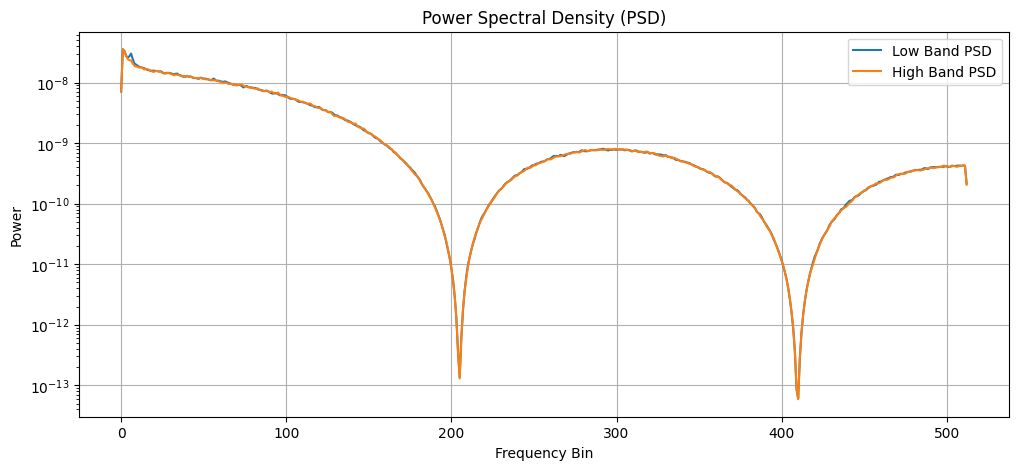

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy import signal
import pandas as pd

# --- Parameters ---
feat_name = 'SPEC'      # Use 'SPEC' for spectrum in dB (matching training)
n_per_seg = 1024        # Number of samples per segment for PSD computation
window_size = 5         # Window size for moving average filter

# --- Define Functions ---
def moving_average_filter(data, window_size=5):
    """
    Applies a moving average filter (FIR filter with uniform weights)
    to smooth the input data.
    """
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def extract_dronerf_features(signal_low, signal_high, fs, n_per_seg, feat_name='SPEC', to_norm=True):
    """
    Compute PSD features for low and high bands using Welch's method,
    optionally convert to dB (if feat_name is 'SPEC'), and normalize.
    The two PSDs are concatenated to form a single feature vector.
    
    Parameters:
      signal_low: low band signal (1D numpy array)
      signal_high: high band signal (1D numpy array)
      fs: sampling rate in Hz
      n_per_seg: number of samples per segment (for Welch's method)
      feat_name: if 'PSD' returns linear PSD; if 'SPEC', converts to dB
      to_norm: if True, normalizes the final feature vector
      
    Returns:
      Feature vector (1D numpy array)
    """
    # Compute PSD for low band
    freqs_low, psd_low = signal.welch(signal_low, fs, nperseg=n_per_seg)
    # Compute PSD for high band
    freqs_high, psd_high = signal.welch(signal_high, fs, nperseg=n_per_seg)
    
    # Concatenate PSD features
    feat = np.concatenate((psd_low, psd_high))
    
    # Convert to dB if feat_name is 'SPEC'
    if feat_name == 'SPEC':
        feat = -10 * np.log10(feat + 1e-8)  # add epsilon to avoid log(0)
    
    # Normalize feature vector if required
    if to_norm and np.max(feat) != 0:
        feat = feat / np.max(feat)
    
    return feat

def load_model(model_path):
    """Load a trained classification model from a pickle file."""
    try:
        with open(model_path, 'rb') as f:
            model = pickle.load(f)
        print(f"Model loaded from: {model_path}")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

# --- Main Prediction Script ---
def main():
    # Set the sampling rate. This should match what was used during training.
    fs = 40e6  # For example, 40 MHz
    
    # Path to your CSV file with the data
    csv_path = r'Data\pluto_sdr_iq_data_20250320_122645.csv'  # Replace with your actual CSV file path
    
    # Read the CSV file using pandas
    df = pd.read_csv(csv_path)
    # Assuming the column names are: "Sample", "I", "Q", "Magnitude", "Phase"
    # We'll use the "Magnitude" column for this example
    magnitude_data = df['Magnitude'].values
    
    # Check that we have enough data to split into two bands
    total_samples = len(magnitude_data)
    if total_samples % 2 != 0:
        print("Warning: Number of samples is odd. Truncating one sample.")
        magnitude_data = magnitude_data[:-1]
        total_samples = len(magnitude_data)
    
    # Split data into two halves (first half = low band, second half = high band)
    mid_point = total_samples // 2
    low_band = magnitude_data[:mid_point]
    high_band = magnitude_data[mid_point:]
    
    # Optionally apply moving average filter (as done in training)
    filtered_low = moving_average_filter(low_band, window_size)
    filtered_high = moving_average_filter(high_band, window_size)
    
    # Extract feature vector (this should produce the same dimension as during training)
    feature_vector = extract_dronerf_features(filtered_low, filtered_high, fs, n_per_seg, feat_name=feat_name, to_norm=True)
    # Reshape to 2D array as expected by scikit-learn
    feature_vector = feature_vector.reshape(1, -1)
    
    # Load the trained model (update the path accordingly)
    # 'drone_detector_svm.pkl'
    model_path = 'drone_detector_stratified_model.pkl'  # Replace with your actual model path
    model = load_model(model_path)
    if model is None:
        return
    
    # Make prediction
    prediction = model.predict(feature_vector)
    print("Prediction:", prediction)
    
    # Optionally, you can also plot the PSDs of the low and high bands for visualization
    freqs_low, psd_low = signal.welch(filtered_low, fs, nperseg=n_per_seg)
    freqs_high, psd_high = signal.welch(filtered_high, fs, nperseg=n_per_seg)
    
    plt.figure(figsize=(12, 5))
    plt.semilogy(psd_low, label='Low Band PSD')
    plt.semilogy(psd_high, label='High Band PSD')
    plt.title('Power Spectral Density (PSD)')
    plt.xlabel('Frequency Bin')
    plt.ylabel('Power')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()


Total segments found: 37
Model loaded from: drone_detector_stratified_model.pkl
Segment 1: Prediction = 0
Model loaded from: drone_detector_stratified_model.pkl
Segment 2: Prediction = 0
Model loaded from: drone_detector_stratified_model.pkl
Segment 3: Prediction = 0
Model loaded from: drone_detector_stratified_model.pkl
Segment 4: Prediction = 0
Model loaded from: drone_detector_stratified_model.pkl
Segment 5: Prediction = 0
Model loaded from: drone_detector_stratified_model.pkl
Segment 6: Prediction = 0
Model loaded from: drone_detector_stratified_model.pkl
Segment 7: Prediction = 0
Model loaded from: drone_detector_stratified_model.pkl
Segment 8: Prediction = 0
Model loaded from: drone_detector_stratified_model.pkl
Segment 9: Prediction = 0
Model loaded from: drone_detector_stratified_model.pkl
Segment 10: Prediction = 0
Model loaded from: drone_detector_stratified_model.pkl
Segment 11: Prediction = 0
Model loaded from: drone_detector_stratified_model.pkl
Segment 12: Prediction = 0


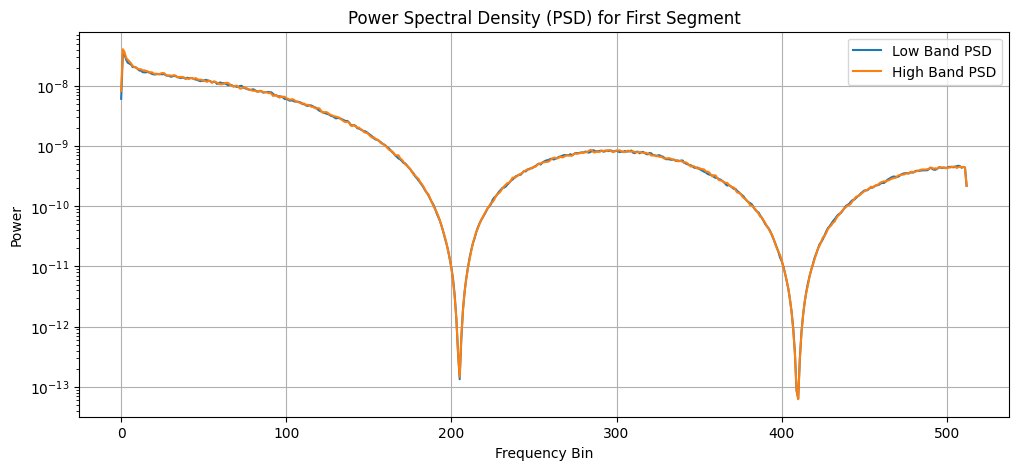

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy import signal
import pandas as pd


feat_name = 'SPEC'     
n_per_seg = 1024     
window_size = 5       

t_seg = 20             


def moving_average_filter(data, window_size=5):
    """
    Applies a moving average filter (FIR filter with uniform weights)
    to smooth the input data.
    """
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def extract_dronerf_features(signal_low, signal_high, fs, n_per_seg, feat_name='SPEC', to_norm=True):
    """
    Compute PSD features for low and high bands using Welch's method,
    optionally convert to dB (if feat_name is 'SPEC'), and normalize.
    The two PSDs are concatenated to form a single feature vector.
    
    Parameters:
      signal_low: low band signal (1D numpy array)
      signal_high: high band signal (1D numpy array)
      fs: sampling rate in Hz
      n_per_seg: number of samples per segment (for Welch's method)
      feat_name: if 'PSD' returns linear PSD; if 'SPEC', converts to dB
      to_norm: if True, normalizes the final feature vector
      
    Returns:
      Feature vector (1D numpy array)
    """
 
    freqs_low, psd_low = signal.welch(signal_low, fs, nperseg=n_per_seg)
   
    freqs_high, psd_high = signal.welch(signal_high, fs, nperseg=n_per_seg)
    
    
    feat = np.concatenate((psd_low, psd_high))
    

    if feat_name == 'SPEC':
        feat = -10 * np.log10(feat + 1e-8) 
    

    if to_norm and np.max(feat) != 0:
        feat = feat / np.max(feat)
    
    return feat

def load_model(model_path):
    """Load a trained classification model from a pickle file."""
    try:
        with open(model_path, 'rb') as f:
            model = pickle.load(f)
        print(f"Model loaded from: {model_path}")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None


def main():

    fs = 40e6  
   
    csv_path = r'Data\pluto_sdr_iq_data_20250320_122718.csv' 
    
    # Read the CSV file using pandas
    df = pd.read_csv(csv_path)
 
    magnitude_data = df['Magnitude'].values
    
    total_samples = len(magnitude_data)

    samples_per_band = int(t_seg / 1000 * fs)
 
    segment_length = 2 * samples_per_band
    
    if total_samples < segment_length:
        print("Error: Not enough samples in the CSV file to form a single segment.")
        return
    
 
    num_segments = total_samples // segment_length
    print(f"Total segments found: {num_segments}")
    

    predictions = []
    

    for i in range(num_segments):
        segment = magnitude_data[i * segment_length : (i + 1) * segment_length]

        low_band = segment[:samples_per_band]
        high_band = segment[samples_per_band:]
        
 
        filtered_low = moving_average_filter(low_band, window_size)
        filtered_high = moving_average_filter(high_band, window_size)
        
  
        feature_vector = extract_dronerf_features(filtered_low, filtered_high, fs, n_per_seg, feat_name=feat_name, to_norm=True)
       
        feature_vector = feature_vector.reshape(1, -1)
        
   
        model_path = 'drone_detector_stratified_model.pkl' 
        model = load_model(model_path)
        if model is None:
            return
        
    
        pred = model.predict(feature_vector)
        predictions.append(pred[0])
        print(f"Segment {i+1}: Prediction = {pred[0]}")
    
   
    print("\nFinal Predictions for each segment:")
    print(predictions)
    

    freqs_low, psd_low = signal.welch(filtered_low, fs, nperseg=n_per_seg)
    freqs_high, psd_high = signal.welch(filtered_high, fs, nperseg=n_per_seg)
    
    plt.figure(figsize=(12, 5))
    plt.semilogy(psd_low, label='Low Band PSD')
    plt.semilogy(psd_high, label='High Band PSD')
    plt.title('Power Spectral Density (PSD) for First Segment')
    plt.xlabel('Frequency Bin')
    plt.ylabel('Power')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()
